In [1]:
import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency
from scipy.stats import fisher_exact
from scipy.stats import chi2
import numpy as np

# Plot data using Plotly
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "browser"

# Matplotlib and Seaborn
import matplotlib.pyplot as plt
import seaborn as sns

# For forest plot
import forestplot as fp


In [2]:
def extract_elof_genes(row, pli: float, oe_lof_upper: float, phaplo: float):
    if (row['pLI'] > pli
            and row['oe_lof_upper'] < oe_lof_upper
            and row['pHaplo'] >= phaplo):
        return True
    else:
        return False 

def extract_g2pLoF_genes(x):
    if 'absent gene product' in x:
        return 'PASS'
    else:
        return '.'

def extract_definitive(x):
    if x == 'definitive':
        return 'PASS'
    else:
        return '.'

def extract_strong(x):
    if (x == 'definitive' or x == 'strong'):
        return 'PASS'
    else:
        return '.'

def extract_moderate(x):
    if (x == 'definitive' or x == 'strong' or x == 'moderate'):
        return 'PASS'
    else:
        return '.'
        
def create_gene_list(
        ajhg: pd.DataFrame, alldf: pd.DataFrame,
        higene: pd.DataFrame, gnomad: pd.DataFrame,
        set_name: str, pli: float, oe_lof_upper: float, 
        phaplo: float, hi: int, dcpr_definitive: str, 
        ) -> set:
    
    # AJHG genes 
    ajhg_genes = set(ajhg['gene'])

    # HI genes
    hi_genes = set(higene.loc[higene['HIscore'] >= hi, 'gene'])
    
    # Extract G2P genes
    alldf_filterd = alldf[alldf[f"{dcpr_definitive}FILTER"] == 'PASS']
    dcpr_genes = set(alldf_filterd['gene'])
    
    # Filteration of pLI, oe_lof_upper and pHaplo score
    gnomad['is_eLoF'] = gnomad.apply(
        extract_elof_genes, args=(pli, oe_lof_upper, phaplo), axis=1)
    gnomad_genes = set(gnomad.loc[gnomad['is_eLoF'] == True, 'gene'])

    # Union of all eLoF genes
    gene_set: set = (gnomad_genes).union(dcpr_genes).union(hi_genes).union(ajhg_genes)
    
    # Count
    print(f"{set_name} AJHG:DCPR:HI:pHaplo:Total - {len(ajhg_genes)} {len(dcpr_genes)} {len(hi_genes)} {len(gnomad_genes)} {len(gene_set)}")
    
    return set_name, gene_set


def create_individual_gene_list(
        ajhg: pd.DataFrame, alldf: pd.DataFrame,
        higene: pd.DataFrame, gnomad: pd.DataFrame,
        set_name: str, pli: float, oe_lof_upper: float, 
        phaplo: float, hi: int, dcpr_definitive: str
        ) -> tuple:
    
    # AJHG genes 
    ajhg_genes = set(ajhg['gene'])

    # HI genes
    higene = higene.astype({'HIscore': int})
    higene = higene.loc[higene['HIscore'] >= hi, 'gene']
    hi_genes = set(higene)
    
    # Extract G2P genes
    alldf_filterd = alldf[alldf[f"{dcpr_definitive}FILTER"] == 'PASS']
    dcpr_genes = set(alldf_filterd['gene'])
    
    # Filteration of pLI, oe_lof_upper and pHaplo score
    gnomad['is_eLoF'] = gnomad.apply(
        extract_elof_genes, args=(pli, oe_lof_upper, phaplo), axis=1)
    gnomad_genes = set(gnomad.loc[gnomad['is_eLoF'] == True, 'gene'])

    return ajhg_genes, dcpr_genes, hi_genes, gnomad_genes


def calc_odds_ratio(
        group: str, label: str,
        a: int, b: int, c: int, d: int, z: float) -> tuple:
    
    odds_ratio = (a * d) / (b * c)
    log_odds = np.log(odds_ratio)
    se = np.sqrt(1/a + 1/b + 1/c + 1/d)
    logci: tuple = log_odds - z * se, log_odds + z * se

    # Example of a contingency table for the odds ratio calculation
    # |-----------|----------|----------|
    # |           | Positive | Negative |
    # |-----------|----------|----------|
    # | eLoF      | a        | b        |
    # | Not eLoF  | c        | d        |
    # |-----------|----------|----------|
    # z = 1.96 for 95% CI z: float
    # z = 2.58 for 99% CI
    # ci: tuple = np.exp(log_odds - z * se), np.exp(log_odds + z * se)

    # Chi2 test
    chi2, p = chi2_contingency([[a, b], [c, d]])[:2]

    # result_logor = '{:.2f}'.format(log_odds)
    # result_ci_lower = '{:.3f}'.format(logci[0])
    # result_ci_upper = '{:.3f}'.format(logci[1])

    return ['{:.3f}'.format(log_odds), '{:.3f}'.format(logci[0]), '{:.3f}'.format(logci[1]), p, group, label]

In [3]:
### Lodading canonical transcripts
canonlist = '../01_CanonicalTranscripts/CanonicalTranscripts.exoncount.tsv'
canon = pd.read_table(canonlist, sep='\t', header=0)
canon_set = set(canon['ENST'])

# Curation data
ajhg_path = 'AJHG_ClinGenLoF_genes.txt.gz'
hi_path = 'ClinGen_haploinsufficiency_gene_GRCh37.bed'
gnomad_path = 'gnomad.v2.1.1.lof_metrics.by_gene.txt.gz'
phaplo_path = 'Collins_rCNV_2022.dosage_sensitivity_scores.tsv.gz'

# G2P data
dd = './DDG2P.csv.gz'
eye = './EyeG2P.csv.gz'
skin = './SkinG2P.csv.gz'
cancer = './CancerG2P.csv.gz'
cardiac = './CardiacG2P.csv.gz'
skeletal = './SkeletalG2P.csv.gz'

# Validation set
am_path = 'AlphaMissense_gene_hg19.tsv.gz'
am_path = 'AlphaMissense_gene_level_list.txt'
genovo_path = 'GenovoLOEUF.txt.gz'
gnocchi_path = 'EnhancerGnocchi.txt.gz'

# Load data
ajhg = pd.read_csv(
    ajhg_path, sep='\t', header=None, skiprows=1,
    names=['gene', 'pLI', 'RefSeq', 'SpliceAcceptor', 'SpliceDonor'],
    usecols=['gene', 'RefSeq']) 

higene = pd.read_csv(
    hi_path, sep='\t', header=None, skiprows=1,
    names=['CHROM', 'start', 'end', 'gene', 'HIscore'],
    usecols=['gene', 'HIscore']
    ) 

gnomad = pd.read_csv(
    gnomad_path, sep='\t', compression='gzip',
    usecols=['gene', 'pLI', 'oe_lof_upper', 'transcript', 'cds_length']
    )

gnomad['is_canon'] = gnomad['transcript'].apply(
    lambda x: True if x in canon_set else False)

phaplo = pd.read_csv(
    phaplo_path, sep='\t', header=None, compression='gzip', skiprows=1,
    names=['gene', 'pHaplo', 'pTriplo'],
    usecols=['gene', 'pHaplo']
    ) 

# Merge gnomad and phaplo
gnomad = pd.merge(gnomad, phaplo, how='left',
                  left_on='gene', right_on='gene')

#### Extract non-canonical ENST and shorter cds transcript from duplicated genes
gnomad = gnomad.loc[(gnomad['transcript'] != 'ENST00000368073')] 
gnomad = gnomad.loc[(gnomad['transcript'] != 'ENST00000608209')] 


#### Create a set of union of ajhg , higene and gnomad genes
all_genes_set: set = set(ajhg['gene']).union(set(higene['gene'])).union(set(gnomad['gene']))
all_genes: pd.DataFrame = pd.DataFrame(all_genes_set, columns=['gene'])


#### G2P data 
dddf = pd.read_csv(dd, sep=',', header=0, compression='infer')
eyedf = pd.read_csv(eye, sep=',', header=0, compression='infer')
skidf = pd.read_csv(skin, sep=',', header=0, compression='infer')
candf = pd.read_csv(cancer, sep=',', header=0, compression='infer')
cardf = pd.read_csv(cardiac, sep=',', header=0, compression='infer')
skedf = pd.read_csv(skeletal, sep=',', header=0, compression='infer')
dfs = [dddf, eyedf, skidf, candf, cardf, skedf]

# Genovo
genovo = pd.read_csv(
    genovo_path, sep='\t', compression='gzip',
    usecols=['enstID', 'enstVersion', 'genovo_LOEUF_corrected']
    )

# Enhancer Gnocchi
gnocchi = pd.read_csv(
    gnocchi_path, sep='\t', compression='gzip',
    usecols=['gene', 'enhancer_Gnocchi']
    )

# AlphaMissense
am = pd.read_csv(am_path, sep='\t', compression='infer')
am = am[['gene', 'transcript', 'mean_am_pathogenicity_bin', 'mean_am_pathogenicity']]

rename_cols = {
    'gene symbol': 'gene',
    'prev symbols': 'prev_symbols', 
    'hgnc id': 'hgnc_id',
    'gene mim': 'gene_mim', 
    'mutation consequence': 'mutation_consequence',
    'confidence category': 'confidence_category',
    'allelic requirement': 'allelic_requirement', 
    'disease name': 'disease_name'
    }

pickup_cols = [
    'gene', 'prev_symbols', 'hgnc_id',  
    'mutation_consequence', 'confidence_category', 
    'allelic_requirement', 'panel', 'disease_name', 
    'g2pLoF', 'definitiveFILTER', 'strongFILTER','moderateFILTER'
    ]


In [4]:
for df in dfs:
    # df['g2pLoF'] = df['mutation consequence'].apply(extract_g2pLoF_genes)
    df['g2pLoF'] = df['mutation consequence'].apply(lambda x: 'PASS' if 'absent gene product' in x else '.')

for df in dfs:
    df['definitiveFILTER'] = df['confidence category'].apply(extract_definitive)
    df['strongFILTER'] = df['confidence category'].apply(extract_strong)
    df['moderateFILTER'] = df['confidence category'].apply(extract_moderate)

### Rename columns
dddf = dddf.rename(columns=rename_cols)
eyedf = eyedf.rename(columns=rename_cols)
skidf = skidf.rename(columns=rename_cols)
candf = candf.rename(columns=rename_cols)
cardf = cardf.rename(columns=rename_cols)
skedf = skedf.rename(columns=rename_cols)

### Extract columns for analysis
dddf = dddf[pickup_cols]
eyedf = eyedf[pickup_cols]
skidf = skidf[pickup_cols]
candf = candf[pickup_cols]
cardf = cardf[pickup_cols]
skedf = skedf[pickup_cols]

### Extract LoF genes
lof_dd = dddf[dddf['g2pLoF'] == 'PASS']
lof_eye = eyedf[eyedf['g2pLoF'] == 'PASS']
lof_ski = skidf[skidf['g2pLoF'] == 'PASS']
lof_can = candf[candf['g2pLoF'] == 'PASS']
lof_car = cardf[cardf['g2pLoF'] == 'PASS']
lof_ske = skedf[skedf['g2pLoF'] == 'PASS']

### Concatnate dataframes
alldf = pd.concat([lof_dd, lof_eye, lof_ski, lof_can, lof_car, lof_ske])
alldf.fillna(value='.', inplace=True)
alldf = alldf.drop_duplicates(subset='gene')

##### Create a set of union of all gene lists #####
ajhg_genes = set(ajhg['gene'])
dcpr_genes = set(alldf['gene'])
higene = higene.loc[
    ((higene['HIscore'] == 2) | (higene['HIscore'] == 3)), ['gene', 'HIscore']]
hi_genes = set(higene)
gnomad_genes = set(gnomad['gene'])

gene_set: set = gnomad_genes.union(dcpr_genes).union(hi_genes).union(ajhg_genes)
all_genes = pd.DataFrame(all_genes_set, columns=['gene'])

# Merge canon
print(len(all_genes))
all_genes = pd.merge(all_genes, canon, how='left', left_on='gene', right_on='GeneSymbol')

# Annotate gnocchi score
all_genes = pd.merge(all_genes, gnocchi, how='left', left_on='gene', right_on='gene')

# Annotate genovo score
all_genes = pd.merge(all_genes, genovo, how='left', left_on='ENST', right_on='enstID')

# Annotate AM score
all_genes = pd.merge(all_genes, am, how='left', left_on='gene', right_on='gene')
print(len(all_genes))

### Extract genes with strong evidence
# alldf_filterd = alldf[alldf['strongFILTER'] == 'PASS']
# alldf_filterd = alldf_filterd.drop_duplicates(subset='gene')

# # Gene lists from 4 sources
# ajhg_genes = ajhg['gene']
# dcpr_genes = alldf_filterd['gene']
# hi_genes = higene.loc[higene['HIscore'] == 3, 'gene']
# gnomad_genes = gnomad.loc[gnomad['is_eLoF'] == True, 'gene']
# elofs = set(gnomad_genes).union(dcpr_genes).union(hi_genes).union(ajhg_genes)

"""
Conditions for pLI, oe_lof_upper and pHaplo score and DCIPHER definitive
Set 1: pLI >= 0.9, oe_lof_upper < 0.35, pHaplo >= 0.86, and "Strong" definitive
Set 2: pLI >= 0.9, oe_lof_upper < 0.35, pHaplo >= 0.86, and "Moderate" definitive
Set 3: pLI >= 0.9, oe_lof_upper < 0.35, pHaplo >= 0.86, and "Definitive" definitive
Set 4: pLI >= 0.9, oe_lof_upper < 0.35, pHaplo >= 0.55, and "Strong" definitive
Set 5: pLI >= 0.9, oe_lof_upper < 0.35, pHaplo >= 0.55, and "Moderate" definitive
set 6: pLI >= 0.9, oe_lof_upper < 0.35, pHaplo >= 0.55, and "Definitive" definitive
Set 7: pLI >= 0.9, oe_lof_upper < 0.268, pHaplo >= 0.86, and "Strong" definitive
Set 8: pLI >= 0.9, oe_lof_upper < 0.268, pHaplo >= 0.86, and "Moderate" definitive
Set 9: pLI >= 0.9, oe_lof_upper < 0.268, pHaplo >= 0.86, and "Definitive" definitive
Set 10: pLI >= 0.9, oe_lof_upper < 0.268, pHaplo >= 0.55, and "Strong" definitive
Set 11: pLI >= 0.9, oe_lof_upper < 0.268, pHaplo >= 0.55, and "Moderate" definitive
Set 12: pLI >= 0.9, oe_lof_upper < 0.268, pHaplo >= 0.55, and "Definitive" definitive
"""

# create gene list for each set above conditions
# (set name, pLI, LOEUF, pHaplo, DCIPHER definitive)
conditions_list :list = [
    ('set_01  ', 0.9, 0.35, 0.86, 3, 'moderate'),
    ('set_02  ', 0.9, 0.35, 0.86, 3, 'strong'),
    ('set_03  ', 0.9, 0.35, 0.86, 3, 'definitive'),
    ('set_04  ', 0.9, 0.35, 0.55, 3, 'moderate'),
    ('set_05  ', 0.9, 0.35, 0.55, 3, 'strong'),
    ('set_06  ', 0.9, 0.35, 0.55, 3, 'definitive'),
    ('set_07  ', 0.9, 0.268, 0.86, 3, 'moderate'),
    ('set_08  ', 0.9, 0.268, 0.86, 3, 'strong'),
    ('set_09  ', 0.9, 0.268, 0.86, 3, 'definitive'),
    ('set_10  ', 0.9, 0.268, 0.55, 3, 'moderate'),
    ('set_11  ', 0.9, 0.268, 0.55, 3, 'strong'),
    ('set_12  ', 0.9, 0.268, 0.55, 3, 'definitive'),
    ('set_13  ', 0.9, 0.35, 0.86, 2, 'moderate'),
    ('set_14  ', 0.9, 0.35, 0.86, 2, 'strong'),
    ('set_15  ', 0.9, 0.35, 0.86, 2, 'definitive'),
    ('set_16  ', 0.9, 0.35, 0.55, 2, 'moderate'),
    ('set_17  ', 0.9, 0.35, 0.55, 2, 'strong'),
    ('set_18  ', 0.9, 0.35, 0.55, 2, 'definitive'),
    ('set_19  ', 0.9, 0.268, 0.86, 2, 'moderate'),
    ('set_20  ', 0.9, 0.268, 0.86, 2, 'strong'),
    ('set_21  ', 0.9, 0.268, 0.86, 2, 'definitive'),
    ('set_22  ', 0.9, 0.268, 0.55, 2, 'moderate'),
    ('set_23  ', 0.9, 0.268, 0.55, 2, 'strong'),
    ('set_24  ', 0.9, 0.268, 0.55, 2, 'definitive')
    ]

# Create gene list for each set
elofs :dict = {}
for condition in conditions_list:
    gene_list = create_gene_list(ajhg, alldf, higene, gnomad, *condition)
    elofs[gene_list[0]] = (gene_list[1], condition)

19717
19754
set_01   AJHG:DCPR:HI:pHaplo:Total - 1043 1880 347 1851 3687
set_02   AJHG:DCPR:HI:pHaplo:Total - 1043 1818 347 1851 3646
set_03   AJHG:DCPR:HI:pHaplo:Total - 1043 1329 347 1851 3354
set_04   AJHG:DCPR:HI:pHaplo:Total - 1043 1880 347 2459 4250
set_05   AJHG:DCPR:HI:pHaplo:Total - 1043 1818 347 2459 4210
set_06   AJHG:DCPR:HI:pHaplo:Total - 1043 1329 347 2459 3931
set_07   AJHG:DCPR:HI:pHaplo:Total - 1043 1880 347 1355 3264
set_08   AJHG:DCPR:HI:pHaplo:Total - 1043 1818 347 1355 3221
set_09   AJHG:DCPR:HI:pHaplo:Total - 1043 1329 347 1355 2922
set_10   AJHG:DCPR:HI:pHaplo:Total - 1043 1880 347 1694 3582
set_11   AJHG:DCPR:HI:pHaplo:Total - 1043 1818 347 1694 3539
set_12   AJHG:DCPR:HI:pHaplo:Total - 1043 1329 347 1694 3246
set_13   AJHG:DCPR:HI:pHaplo:Total - 1043 1880 370 1851 3688
set_14   AJHG:DCPR:HI:pHaplo:Total - 1043 1818 370 1851 3647
set_15   AJHG:DCPR:HI:pHaplo:Total - 1043 1329 370 1851 3355
set_16   AJHG:DCPR:HI:pHaplo:Total - 1043 1880 370 2459 4251
set_17   AJH

In [5]:
# Prepare DataFrame for analysis with Gnocchi score
gnocchi['in_analysis'] = gnocchi['gene'].apply(lambda x: True if x in all_genes['gene'].values else False)

# Prepare DataFrame for analysis with Genovo score
genovo_compare = all_genes.loc[all_genes['genovo_LOEUF_corrected'].notnull()]
for tx in ['ENST00000260364.9_3', 'ENST00000394800.6_6', 'ENST00000554914.1_5']:
    genovo_compare = genovo_compare.loc[genovo_compare['ENST_Full'] != tx]
genovo_compare = genovo_compare[['gene', 'genovo_LOEUF_corrected']]

# Prepare DataFrame for analysis with AM score
am_compare = all_genes.loc[all_genes['mean_am_pathogenicity'].notnull()].copy()
am_compare.drop_duplicates(subset=['gene', 'ENST_Full'], inplace=True)
am_compare.loc[am_compare['gene'].duplicated(keep=False), ['gene', 'ENST_Full', 'Tag']]
exclued_tx = [
    'ENST00000568033.1_4',
    'ENST00000534261.4_5',
    'ENST00000512194.2_5',
    'ENST00000260364.9_3',
    'ENST00000449680.5_4',
    'ENST00000609375.1_7',
    'ENST00000649912.1_4',
    'ENST00000449552.6_6',
    'ENST00000546983.2_9',
    'ENST00000554914.1_5',
    'ENST00000439928.2_2',
    'ENST00000646171.1_11'
]

for tx in exclued_tx:
    am_compare = am_compare.loc[am_compare['ENST_Full'] != tx]

am_compare = am_compare[['gene', 'mean_am_pathogenicity_bin', 'mean_am_pathogenicity']]

## Plot forest plot for comparison of log odds ratio

In [6]:
## Odds ratio calculation
results_fp = [] # Initialize results list for forest plot

# For Enhancer Gnocchi
for set_name, data in elofs.items():
    gene_set = data[0]
    gnocchi['is_eLoF'] = gnocchi['gene'].apply(lambda x: True if x in gene_set else False)
    genovo_compare['is_eLoF'] = genovo_compare['gene'].apply(lambda x: True if x in gene_set else False)
    am_compare['is_eLoF'] = am_compare['gene'].apply(lambda x: True if x in gene_set else False)
    
    for cutoff in [4]:
        gnocchi['is_constrained'] = gnocchi['enhancer_Gnocchi'].apply(lambda x: True if x >= cutoff else False)

        a = sum(gnocchi['is_constrained'] & gnocchi['is_eLoF'])
        b = sum(gnocchi['is_constrained'] & ~gnocchi['is_eLoF'])
        c = sum(~gnocchi['is_constrained'] & gnocchi['is_eLoF'])
        d = sum(~gnocchi['is_constrained'] & ~gnocchi['is_eLoF'])

        result = calc_odds_ratio("Enhancer Gnocchi", f">= {cutoff}", a, b, c, d, 1.96)
        result.append(set_name)
        for i in range(1, 6):
            result.append(data[1][i])
        results_fp.append(result)

    # For AM
    # for cutoff in [0, 1, 2]:
    for cutoff in [0]:
        am_compare['is_constrained'] = am_compare['mean_am_pathogenicity_bin'].apply(lambda x: True if x <= cutoff else False)

        a = sum(am_compare['is_constrained'] & am_compare['is_eLoF'])
        c = sum(am_compare['is_constrained'] & ~am_compare['is_eLoF'])
        b = sum(~am_compare['is_constrained'] & am_compare['is_eLoF'])
        d = sum(~am_compare['is_constrained'] & ~am_compare['is_eLoF'])

        result = calc_odds_ratio("Gene-level AM pathogenicity", f"bin: {int(cutoff)}", a, b, c, d, 1.96)
        result.append(set_name)
        for i in range(1, 6):
            result.append(data[1][i])
        results_fp.append(result)

    # For Genovo
    # for cutoff in [0.2, 0.35, 0.5]:
    for cutoff in [0.35]:
        genovo_compare['is_constrained'] = genovo_compare['genovo_LOEUF_corrected'].apply(lambda x: True if x < cutoff else False)

        a = sum(genovo_compare['is_constrained'] & genovo_compare['is_eLoF'])
        b = sum(genovo_compare['is_constrained'] & ~genovo_compare['is_eLoF'])
        c = sum(~genovo_compare['is_constrained'] & genovo_compare['is_eLoF'])
        d = sum(~genovo_compare['is_constrained'] & ~genovo_compare['is_eLoF'])

        result = calc_odds_ratio('Genovo LOEUF', f"< {cutoff}", a, b, c, d, 1.96)
        result.append(set_name)
        for i in range(1, 6):
            result.append(data[1][i])
        results_fp.append(result)

# Create a dataframe for forest plot
colnames = ['Odds ratio', "CI_lower", "CI_upper", "p-value", "Group", "Label", "Set", "pLI", "oe_lof_upper", "pHaplo", "HI_score", "DECIPHER_definitive"]
fpdf = pd.DataFrame(results_fp, columns=colnames)
fpdf = fpdf.astype({'Odds ratio': float, "CI_lower": float, "CI_upper": float, 
                    "p-value": float, "Group": str, "Label":str, "Set": str})

fpdf['logORci'] = fpdf.apply(lambda x: f"{x['Odds ratio']} ({x['CI_lower']} to {x['CI_upper']})", axis=1)


In [7]:
ns = [3687, 3646, 3354, 4250, 4210, 3931, 3264, 3221, 2922, 3582, 3539, 3246, 
      3688, 3647, 3355, 4251, 4211, 3932, 3266, 3223, 2924, 3584, 3541, 3248]
rows = [i for i in range(0, 72, 3)]

for i, n in zip(rows, ns):
    fpdf.loc[i, 'logorci_gnoc'] = str(fpdf.loc[i, 'logORci']).ljust(25)
    fpdf.loc[i, 'logorci_am'] = str(fpdf.loc[i + 1, 'logORci']).ljust(25)
    fpdf.loc[i, 'logorci_genovo'] = str(fpdf.loc[i + 2, 'logORci']).ljust(25)
    fpdf.loc[i, 'Number of genes'] = f"    {str(n)}"
    fpdf.loc[i, 'logorci_gnoc'] = str(fpdf.loc[i, 'logORci']).ljust(25)
    fpdf.loc[i, "DECIPHER_definitive"] = f"  {fpdf.loc[i, 'DECIPHER_definitive']}"

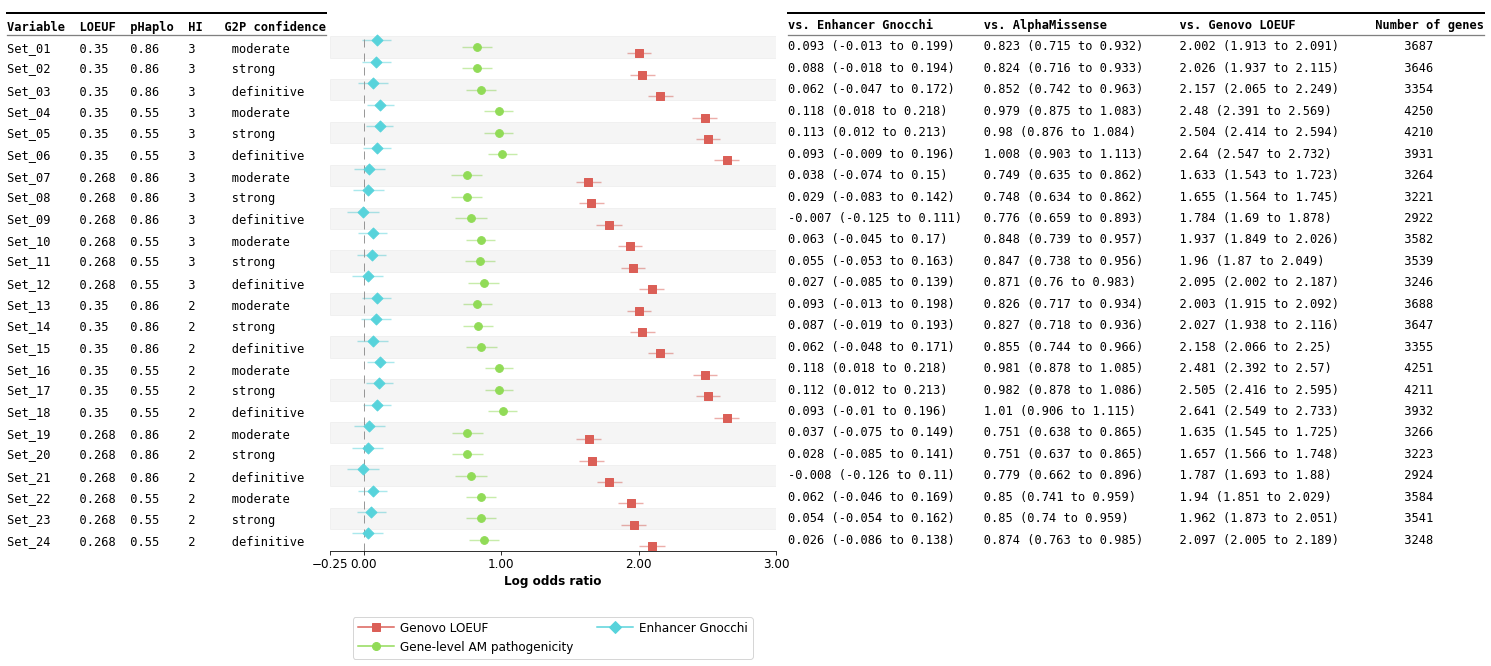

In [8]:
std_opts = dict(
    estimate = "Odds ratio",
    ll = "CI_lower", hl = "CI_upper", 
    varlabel = "Set", 
    capitalize = "capitalize",
    table = True,
    # rightannote=['Model'],
    # right_annoteheaders=['Set name'],
    xlabel = "Log odds ratio",  # x-label title
    ylabel = "log odds ratio",  # y-label title
    annote = ['oe_lof_upper', 'pHaplo', "HI_score", 'DECIPHER_definitive'] ,
    annoteheaders = ['LOEUF', 'pHaplo', "HI", 'G2P confidence'],
    rightannote = ['logorci_gnoc', 'logorci_am', 'logorci_genovo', 'Number of genes'],
    right_annoteheaders = ['vs. Enhancer Gnocchi', 'vs. AlphaMissense', 'vs. Genovo LOEUF', 'Number of genes'],
    figsize = (8, 10),
    return_df = False,
    markersize = 60,
    offset = 0.3, # override default vertical offset between models (0.0 to 1.0)
    xlinestyle = (0, (8, 6)),  # long dash for x-reference line
    xlinecolor = ".6",  # gray color for x-reference line
    xtick_size = 12,
    color_alt_rows=True,
)

fp_all = fp.mforestplot(
    dataframe = fpdf,
    xticks = [-0.25, 0, 1, 2, 3],
    **std_opts,
    logscale=False,
    model_col = "Group",
    mcolor = list(sns.hls_palette(4)),
    )

# fpdf_gnocchi = fpdf[fpdf['Group'] == 'Enhancer Gnocchi']
# fp_gnocchi = fp.mforestplot(
#     dataframe = fpdf_gnocchi,
#     xticks = [-0.25, 0, 0.5, 1, 1.5],
#     **std_opts,
#     logscale=False,
#     model_col = "Group",
#     mcolor = list(sns.hls_palette(4)),
#     )

# fpdf_am = fpdf[fpdf['Group'] == 'Gene-level AM pathogenicity']
# fp_am = fp.mforestplot(
#     dataframe = fpdf_am,
#     xticks = [-0.25, 0, 0.5, 1, 1.5],
#     **std_opts,
#     logscale=False,
#     model_col = "Label",
#     mcolor = list(sns.hls_palette(4)),
#     )

# fpdf_genovo = fpdf[fpdf['Group'] == 'Genovo LOEUF']
# fp_genovo = fp.mforestplot(
#     dataframe = fpdf_genovo,
#     xticks = [-0.25, 1, 2, 3.5],
#     **std_opts,
#     logscale=False,
#     model_col = "Label",
#     mcolor = list(sns.hls_palette(4)),
#     )

In [25]:
conditions_list[15]

('set_16  ', 0.9, 0.35, 0.55, 2, 'moderate')

In [28]:
final_conditions = conditions_list[15]
final_elofs = create_gene_list(ajhg, alldf, higene, gnomad, *final_conditions)

final_elofs_gene = final_elofs[1]
print(len(final_elofs_gene))
df_final_elofs = pd.DataFrame(final_elofs_gene, columns=['gene'])

# Output final gene list as tsv
df_final_elofs.to_csv(f'final_elofs_{final_conditions[0]}.tsv', sep='\t', index=False)

set_16   AJHG:DCPR:HI:pHaplo:Total - 1043 1880 370 2459 4251
4251


In [26]:
import os
import sys
from pathlib import Path

try: 
    __file__
    sys.path.append(os.path.join(os.path.dirname(__file__)))
except NameError:
    Path().resolve()
    sys.path.append(os.path.join(Path().resolve(), '../..'))

from libs import venn

In [27]:
ajhg_genes, dcpr_genes, hi_genes, gnomad_genes = create_individual_gene_list(ajhg, alldf, higene, gnomad, *final_conditions)


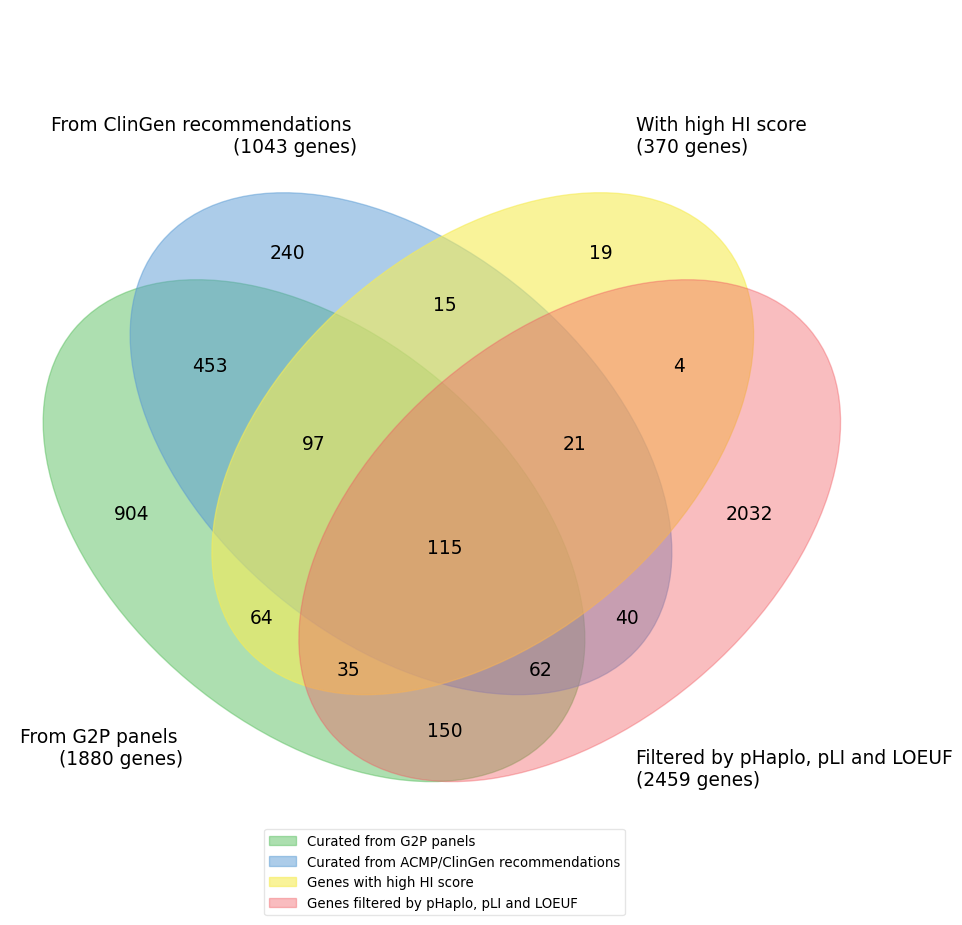

In [29]:

# labels = venn.get_labels([ajhg_genes, dcpr_genes, hi_genes, gnomad_genes], fill=['number'])
# fig, ax = venn.venn4(
labels = get_labels([dcpr_genes, ajhg_genes, hi_genes, gnomad_genes], fill=['number'])
fig, ax = venn4(
       labels, 
       names=[f'From G2P panels \n({len(dcpr_genes)} genes)',
              f'From ClinGen recommendations \n({len(ajhg_genes)} genes)',
              f'With high HI score \n({len(hi_genes)} genes)', 
              f'Filtered by pHaplo, pLI and LOEUF\n({len(gnomad_genes)} genes)'
              ],
       leg_names=[
              'Curated from G2P panels',
              "Curated from ACMP/ClinGen recommendations",
              'Genes with high HI score', 
              'Genes filtered by pHaplo, pLI and LOEUF'
              ]
       )

In [30]:
# Create eLoF gene list for publication
# The columns of gene list are 'Gene symbol', 'pLI', 'oe_lof_upper', 'pHaplo', 'DECIPHER definitive', 'Enhaner Gnocchi', 'Genovo LOEUF', 'AM pathogenicity'

final_genes = pd.merge(df_final_elofs, all_genes, how='left', left_on='gene', right_on='gene')

In [31]:
final_genes.drop(index=final_genes.index[[21, 22, 119, 1835, 3081, 3225]], inplace=True)

In [46]:
for s in final_genes.loc[(final_genes['gene'] == 'SHOX') | (final_genes['gene'] == 'TBCE'), 'Tag']:
	print(s)

CAGE_supported_TSS,basic,Ensembl_canonical,MANE_Select,appris_principal_1,CCDS
CAGE_supported_TSS,basic,Ensembl_canonical,MANE_Select,appris_principal_1,CCDS


In [59]:
# final_genes[final_genes['gene'] == 'PIDD']
final_genes[final_genes['ENST_Full'].isnull()]


,gene,CHROM,Start,End,GeneSymbol,HGNC_ID,ENSG,ENST,ENSG_Full,ENST_Full,enhancer_Gnocchi,enstID,enstVersion,genovo_LOEUF_corrected,transcript,mean_am_pathogenicity
28,GNB2L1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ENST00000512805,0.781106
84,PIDD1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
105,AFG2A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
167,KIRREL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ENST00000359209,0.500788
186,RXYLT1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4221,TMEM57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ENST00000374343,0.561787
4223,KIAA1468,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ENST00000398130,0.515821
4224,HIAT1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ENST00000370152,0.574911
4228,SKIV2L,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ENST00000375394,0.474099


In [48]:
final_genes = final_genes[['gene', 'CHROM', 'Start', 'End', 'GeneSymbol', 'HGNC_ID','ENSG', 'ENST', 'ENSG_Full', 'ENST_Full',
       'enhancer_Gnocchi', 'enstID', 'enstVersion', 'genovo_LOEUF_corrected',
       'transcript','mean_am_pathogenicity']]

NameError: name 'higenes' is not defined

In [40]:
l = [dcpr_genes, ajhg_genes, hi_genes, gnomad_genes]

In [67]:
for i, li in enumerate(l):
    if "MACO1" in li:
        print(f"{i}: {li}")
    else:
        pass

In [69]:
MACO1.loc[MACO1['gene'] == 'MACO1', :]

,gene,RefSeq


#### venn.py functions

In [9]:
# coding: utf-8
from itertools import chain
try:
    # since python 3.10
    from collections.abc import Iterable
except ImportError:
    from collections import Iterable
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import colors
import math

default_colors = [
    # r, g, b, a
    [92, 192, 98, 0.5],
    [90, 155, 212, 0.5],
    [246, 236, 86, 0.6],
    [241, 90, 96, 0.4],
    [255, 117, 0, 0.3],
    [82, 82, 190, 0.2],
]
default_colors = [
    [i[0] / 255.0, i[1] / 255.0, i[2] / 255.0, i[3]]
    for i in default_colors
]

def draw_ellipse(fig, ax, x, y, w, h, a, fillcolor):
    e = patches.Ellipse(
        xy=(x, y),
        width=w,
        height=h,
        angle=a,
        color=fillcolor)
    ax.add_patch(e)

def draw_triangle(fig, ax, x1, y1, x2, y2, x3, y3, fillcolor):
    xy = [
        (x1, y1),
        (x2, y2),
        (x3, y3),
    ]
    polygon = patches.Polygon(
        xy=xy,
        closed=True,
        color=fillcolor)
    ax.add_patch(polygon)

def draw_text(fig, ax, x, y, text, color=[0, 0, 0, 1], fontsize=14, ha="center", va="center"):
    ax.text(
        x, y, text,
        horizontalalignment=ha,
        verticalalignment=va,
        fontsize=fontsize,
        color="black")

def draw_annotate(fig, ax, x, y, textx, texty, text, color=[0, 0, 0, 1], arrowcolor=[0, 0, 0, 0.3]):
    plt.annotate(
        text,
        xy=(x, y),
        xytext=(textx, texty),
        arrowprops=dict(color=arrowcolor, shrink=0, width=0.5, headwidth=8),
        fontsize=14,
        color=color,
        xycoords="data",
        textcoords="data",
        horizontalalignment='center',
        verticalalignment='center'
    )

def get_labels(data, fill=["number"]):
    """
    get a dict of labels for groups in data

    @type data: list[Iterable]
    @rtype: dict[str, str]

    input
      data: data to get label for
      fill: ["number"|"logic"|"percent"]

    return
      labels: a dict of labels for different sets

    example:
    In [12]: get_labels([range(10), range(5,15), range(3,8)], fill=["number"])
    Out[12]:
    {'001': '0',
     '010': '5',
     '011': '0',
     '100': '3',
     '101': '2',
     '110': '2',
     '111': '3'}
    """

    N = len(data)

    sets_data = [set(data[i]) for i in range(N)]  # sets for separate groups
    s_all = set(chain(*data))                     # union of all sets

    # bin(3) --> '0b11', so bin(3).split('0b')[-1] will remove "0b"
    set_collections = {}
    for n in range(1, 2**N):
        key = bin(n).split('0b')[-1].zfill(N)
        value = s_all
        sets_for_intersection = [sets_data[i] for i in range(N) if  key[i] == '1']
        sets_for_difference = [sets_data[i] for i in range(N) if  key[i] == '0']
        for s in sets_for_intersection:
            value = value & s
        for s in sets_for_difference:
            value = value - s
        set_collections[key] = value

    labels = {k: "" for k in set_collections}
    if "logic" in fill:
        for k in set_collections:
            labels[k] = k + ": "
    if "number" in fill:
        for k in set_collections:
            labels[k] += str(len(set_collections[k]))
    if "percent" in fill:
        data_size = len(s_all)
        for k in set_collections:
            labels[k] += "(%.1f%%)" % (100.0 * len(set_collections[k]) / data_size)

    return labels

def venn2(labels, names=['A', 'B'], **options):
    """
    plots a 2-set Venn diagram

    @type labels: dict[str, str]
    @type names: list[str]
    @rtype: (Figure, AxesSubplot)

    input
      labels: a label dict where keys are identified via binary codes ('01', '10', '11'),
              hence a valid set could look like: {'01': 'text 1', '10': 'text 2', '11': 'text 3'}.
              unmentioned codes are considered as ''.
      names:  group names
      more:   colors, figsize, dpi, fontsize

    return
      pyplot Figure and AxesSubplot object
    """
    colors = options.get('colors', [default_colors[i] for i in range(2)])
    figsize = options.get('figsize', (9, 7))
    dpi = options.get('dpi', 96)
    fontsize = options.get('fontsize', 14)

    fig = plt.figure(0, figsize=figsize, dpi=dpi)
    ax = fig.add_subplot(111, aspect='equal')
    ax.set_axis_off()
    ax.set_ylim(bottom=0.0, top=0.7)
    ax.set_xlim(left=0.0, right=1.0)

    # body
    draw_ellipse(fig, ax, 0.375, 0.3, 0.5, 0.5, 0.0, colors[0])
    draw_ellipse(fig, ax, 0.625, 0.3, 0.5, 0.5, 0.0, colors[1])
    draw_text(fig, ax, 0.74, 0.30, labels.get('01', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.26, 0.30, labels.get('10', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.50, 0.30, labels.get('11', ''), fontsize=fontsize)

    # legend
    draw_text(fig, ax, 0.20, 0.56, names[0], colors[0], fontsize=fontsize, ha="right", va="bottom")
    draw_text(fig, ax, 0.80, 0.56, names[1], colors[1], fontsize=fontsize, ha="left", va="bottom")
    leg = ax.legend(names, loc='center left', bbox_to_anchor=(1.0, 0.5), fancybox=True)
    leg.get_frame().set_alpha(0.5)

    return fig, ax

def venn3(labels, names=['A', 'B', 'C'], **options):
    """
    plots a 3-set Venn diagram

    @type labels: dict[str, str]
    @type names: list[str]
    @rtype: (Figure, AxesSubplot)

    input
      labels: a label dict where keys are identified via binary codes ('001', '010', '100', ...),
              hence a valid set could look like: {'001': 'text 1', '010': 'text 2', '100': 'text 3', ...}.
              unmentioned codes are considered as ''.
      names:  group names
      more:   colors, figsize, dpi, fontsize

    return
      pyplot Figure and AxesSubplot object
    """
    colors = options.get('colors', [default_colors[i] for i in range(3)])
    figsize = options.get('figsize', (9, 9))
    dpi = options.get('dpi', 96)
    fontsize = options.get('fontsize', 14)

    fig = plt.figure(0, figsize=figsize, dpi=dpi)
    ax = fig.add_subplot(111, aspect='equal')
    ax.set_axis_off()
    ax.set_ylim(bottom=0.0, top=1.0)
    ax.set_xlim(left=0.0, right=1.0)

    # body
    draw_ellipse(fig, ax, 0.333, 0.633, 0.5, 0.5, 0.0, colors[0])
    draw_ellipse(fig, ax, 0.666, 0.633, 0.5, 0.5, 0.0, colors[1])
    draw_ellipse(fig, ax, 0.500, 0.310, 0.5, 0.5, 0.0, colors[2])
    draw_text(fig, ax, 0.50, 0.27, labels.get('001', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.73, 0.65, labels.get('010', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.61, 0.46, labels.get('011', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.27, 0.65, labels.get('100', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.39, 0.46, labels.get('101', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.50, 0.65, labels.get('110', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.50, 0.51, labels.get('111', ''), fontsize=fontsize)

    # legend
    draw_text(fig, ax, 0.15, 0.87, names[0], colors[0], fontsize=fontsize, ha="right", va="bottom")
    draw_text(fig, ax, 0.85, 0.87, names[1], colors[1], fontsize=fontsize, ha="left", va="bottom")
    draw_text(fig, ax, 0.50, 0.02, names[2], colors[2], fontsize=fontsize, va="top")
    leg = ax.legend(names, loc='center left', bbox_to_anchor=(1.0, 0.5), fancybox=True)
    leg.get_frame().set_alpha(0.5)

    return fig, ax

def venn4(labels, names=['A', 'B', 'C', 'D'], leg_names=['A2', 'B2', 'C2', 'D2'], **options):
    """
    plots a 4-set Venn diagram

    @type labels: dict[str, str]
    @type names: list[str]
    @rtype: (Figure, AxesSubplot)

    input
      labels: a label dict where keys are identified via binary codes ('0001', '0010', '0100', ...),
              hence a valid set could look like: {'0001': 'text 1', '0010': 'text 2', '0100': 'text 3', ...}.
              unmentioned codes are considered as ''.
      names:  group names
      more:   colors, figsize, dpi, fontsize

    return
      pyplot Figure and AxesSubplot object
    """
    colors = options.get('colors', [default_colors[i] for i in range(4)])
    figsize = options.get('figsize', (12, 12))
    dpi = options.get('dpi', 96)
    fontsize = options.get('fontsize', 14)

    fig = plt.figure(0, figsize=figsize, dpi=dpi)
    ax = fig.add_subplot(111, aspect='equal')
    ax.set_axis_off()
    ax.set_ylim(bottom=0.0, top=1.0)
    ax.set_xlim(left=0.0, right=1.0)

    # body
    draw_ellipse(fig, ax, 0.350, 0.400, 0.72, 0.45, 140.0, colors[0])
    draw_ellipse(fig, ax, 0.450, 0.500, 0.72, 0.45, 140.0, colors[1])
    draw_ellipse(fig, ax, 0.544, 0.500, 0.72, 0.45, 40.0, colors[2])
    draw_ellipse(fig, ax, 0.644, 0.400, 0.72, 0.45, 40.0, colors[3])
    draw_text(fig, ax, 0.85, 0.42, labels.get('0001', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.68, 0.72, labels.get('0010', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.77, 0.59, labels.get('0011', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.32, 0.72, labels.get('0100', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.71, 0.30, labels.get('0101', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.50, 0.66, labels.get('0110', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.65, 0.50, labels.get('0111', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.14, 0.42, labels.get('1000', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.50, 0.17, labels.get('1001', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.29, 0.30, labels.get('1010', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.39, 0.24, labels.get('1011', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.23, 0.59, labels.get('1100', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.61, 0.24, labels.get('1101', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.35, 0.50, labels.get('1110', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.50, 0.38, labels.get('1111', ''), fontsize=fontsize)

    # legend
    draw_text(fig, ax, 0.20, 0.15, names[0], colors[0], fontsize=fontsize, ha="right")
    draw_text(fig, ax, 0.40, 0.83, names[1], colors[1], fontsize=fontsize, ha="right", va="bottom")
    draw_text(fig, ax, 0.72, 0.83, names[2], colors[2], fontsize=fontsize, ha="left", va="bottom")
    draw_text(fig, ax, 0.72, 0.15, names[3], colors[3], fontsize=fontsize, ha="left", va="top")
    leg = ax.legend(leg_names, loc='lower center', bbox_to_anchor=(0.5, -0.05), fancybox=True)
    leg.get_frame().set_alpha(0.5)

    return fig, ax

def venn5(labels, names=['A', 'B', 'C', 'D', 'E'], **options):
    """
    plots a 5-set Venn diagram

    @type labels: dict[str, str]
    @type names: list[str]
    @rtype: (Figure, AxesSubplot)

    input
      labels: a label dict where keys are identified via binary codes ('00001', '00010', '00100', ...),
              hence a valid set could look like: {'00001': 'text 1', '00010': 'text 2', '00100': 'text 3', ...}.
              unmentioned codes are considered as ''.
      names:  group names
      more:   colors, figsize, dpi, fontsize

    return
      pyplot Figure and AxesSubplot object
    """
    colors = options.get('colors', [default_colors[i] for i in range(5)])
    figsize = options.get('figsize', (13, 13))
    dpi = options.get('dpi', 96)
    fontsize = options.get('fontsize', 14)

    fig = plt.figure(0, figsize=figsize, dpi=dpi)
    ax = fig.add_subplot(111, aspect='equal')
    ax.set_axis_off()
    ax.set_ylim(bottom=0.0, top=1.0)
    ax.set_xlim(left=0.0, right=1.0)

    # body
    draw_ellipse(fig, ax, 0.428, 0.449, 0.87, 0.50, 155.0, colors[0])
    draw_ellipse(fig, ax, 0.469, 0.543, 0.87, 0.50, 82.0, colors[1])
    draw_ellipse(fig, ax, 0.558, 0.523, 0.87, 0.50, 10.0, colors[2])
    draw_ellipse(fig, ax, 0.578, 0.432, 0.87, 0.50, 118.0, colors[3])
    draw_ellipse(fig, ax, 0.489, 0.383, 0.87, 0.50, 46.0, colors[4])
    draw_text(fig, ax, 0.27, 0.11, labels.get('00001', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.72, 0.11, labels.get('00010', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.55, 0.13, labels.get('00011', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.91, 0.58, labels.get('00100', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.78, 0.64, labels.get('00101', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.84, 0.41, labels.get('00110', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.76, 0.55, labels.get('00111', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.51, 0.90, labels.get('01000', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.39, 0.15, labels.get('01001', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.42, 0.78, labels.get('01010', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.50, 0.15, labels.get('01011', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.67, 0.76, labels.get('01100', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.70, 0.71, labels.get('01101', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.51, 0.74, labels.get('01110', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.64, 0.67, labels.get('01111', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.10, 0.61, labels.get('10000', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.20, 0.31, labels.get('10001', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.76, 0.25, labels.get('10010', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.65, 0.23, labels.get('10011', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.18, 0.50, labels.get('10100', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.21, 0.37, labels.get('10101', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.81, 0.37, labels.get('10110', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.74, 0.40, labels.get('10111', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.27, 0.70, labels.get('11000', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.34, 0.25, labels.get('11001', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.33, 0.72, labels.get('11010', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.51, 0.22, labels.get('11011', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.25, 0.58, labels.get('11100', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.28, 0.39, labels.get('11101', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.36, 0.66, labels.get('11110', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.51, 0.47, labels.get('11111', ''), fontsize=fontsize)

    # legend
    draw_text(fig, ax, 0.02, 0.72, names[0], colors[0], fontsize=fontsize, ha="right")
    draw_text(fig, ax, 0.72, 0.94, names[1], colors[1], fontsize=fontsize, va="bottom")
    draw_text(fig, ax, 0.97, 0.74, names[2], colors[2], fontsize=fontsize, ha="left")
    draw_text(fig, ax, 0.88, 0.05, names[3], colors[3], fontsize=fontsize, ha="left")
    draw_text(fig, ax, 0.12, 0.05, names[4], colors[4], fontsize=fontsize, ha="right")
    leg = ax.legend(names, loc='center left', bbox_to_anchor=(1.0, 0.5), fancybox=True)
    leg.get_frame().set_alpha(0.5)

    return fig, ax

def venn6(labels, names=['A', 'B', 'C', 'D', 'E'], **options):
    """
    plots a 6-set Venn diagram

    @type labels: dict[str, str]
    @type names: list[str]
    @rtype: (Figure, AxesSubplot)

    input
      labels: a label dict where keys are identified via binary codes ('000001', '000010', '000100', ...),
              hence a valid set could look like: {'000001': 'text 1', '000010': 'text 2', '000100': 'text 3', ...}.
              unmentioned codes are considered as ''.
      names:  group names
      more:   colors, figsize, dpi, fontsize

    return
      pyplot Figure and AxesSubplot object
    """
    colors = options.get('colors', [default_colors[i] for i in range(6)])
    figsize = options.get('figsize', (20, 20))
    dpi = options.get('dpi', 96)
    fontsize = options.get('fontsize', 14)

    fig = plt.figure(0, figsize=figsize, dpi=dpi)
    ax = fig.add_subplot(111, aspect='equal')
    ax.set_axis_off()
    ax.set_ylim(bottom=0.230, top=0.845)
    ax.set_xlim(left=0.173, right=0.788)

    # body
    # See https://web.archive.org/web/20040819232503/http://www.hpl.hp.com/techreports/2000/HPL-2000-73.pdf
    draw_triangle(fig, ax, 0.637, 0.921, 0.649, 0.274, 0.188, 0.667, colors[0])
    draw_triangle(fig, ax, 0.981, 0.769, 0.335, 0.191, 0.393, 0.671, colors[1])
    draw_triangle(fig, ax, 0.941, 0.397, 0.292, 0.475, 0.456, 0.747, colors[2])
    draw_triangle(fig, ax, 0.662, 0.119, 0.316, 0.548, 0.662, 0.700, colors[3])
    draw_triangle(fig, ax, 0.309, 0.081, 0.374, 0.718, 0.681, 0.488, colors[4])
    draw_triangle(fig, ax, 0.016, 0.626, 0.726, 0.687, 0.522, 0.327, colors[5])
    draw_text(fig, ax, 0.212, 0.562, labels.get('000001', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.430, 0.249, labels.get('000010', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.356, 0.444, labels.get('000011', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.609, 0.255, labels.get('000100', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.323, 0.546, labels.get('000101', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.513, 0.316, labels.get('000110', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.523, 0.348, labels.get('000111', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.747, 0.458, labels.get('001000', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.325, 0.492, labels.get('001001', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.670, 0.481, labels.get('001010', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.359, 0.478, labels.get('001011', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.653, 0.444, labels.get('001100', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.344, 0.526, labels.get('001101', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.653, 0.466, labels.get('001110', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.363, 0.503, labels.get('001111', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.750, 0.616, labels.get('010000', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.682, 0.654, labels.get('010001', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.402, 0.310, labels.get('010010', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.392, 0.421, labels.get('010011', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.653, 0.691, labels.get('010100', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.651, 0.644, labels.get('010101', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.490, 0.340, labels.get('010110', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.468, 0.399, labels.get('010111', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.692, 0.545, labels.get('011000', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.666, 0.592, labels.get('011001', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.665, 0.496, labels.get('011010', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.374, 0.470, labels.get('011011', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.653, 0.537, labels.get('011100', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.652, 0.579, labels.get('011101', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.653, 0.488, labels.get('011110', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.389, 0.486, labels.get('011111', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.553, 0.806, labels.get('100000', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.313, 0.604, labels.get('100001', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.388, 0.694, labels.get('100010', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.375, 0.633, labels.get('100011', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.605, 0.359, labels.get('100100', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.334, 0.555, labels.get('100101', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.582, 0.397, labels.get('100110', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.542, 0.372, labels.get('100111', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.468, 0.708, labels.get('101000', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.355, 0.572, labels.get('101001', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.420, 0.679, labels.get('101010', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.375, 0.597, labels.get('101011', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.641, 0.436, labels.get('101100', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.348, 0.538, labels.get('101101', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.635, 0.453, labels.get('101110', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.370, 0.548, labels.get('101111', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.594, 0.689, labels.get('110000', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.579, 0.670, labels.get('110001', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.398, 0.670, labels.get('110010', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.395, 0.653, labels.get('110011', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.633, 0.682, labels.get('110100', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.616, 0.656, labels.get('110101', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.587, 0.427, labels.get('110110', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.526, 0.415, labels.get('110111', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.495, 0.677, labels.get('111000', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.505, 0.648, labels.get('111001', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.428, 0.663, labels.get('111010', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.430, 0.631, labels.get('111011', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.639, 0.524, labels.get('111100', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.591, 0.604, labels.get('111101', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.622, 0.477, labels.get('111110', ''), fontsize=fontsize)
    draw_text(fig, ax, 0.501, 0.523, labels.get('111111', ''), fontsize=fontsize)

    # legend
    draw_text(fig, ax, 0.674, 0.824, names[0], colors[0], fontsize=fontsize)
    draw_text(fig, ax, 0.747, 0.751, names[1], colors[1], fontsize=fontsize)
    draw_text(fig, ax, 0.739, 0.396, names[2], colors[2], fontsize=fontsize)
    draw_text(fig, ax, 0.700, 0.247, names[3], colors[3], fontsize=fontsize)
    draw_text(fig, ax, 0.291, 0.255, names[4], colors[4], fontsize=fontsize)
    draw_text(fig, ax, 0.203, 0.484, names[5], colors[5], fontsize=fontsize)
    leg = ax.legend(names, loc='center left', bbox_to_anchor=(1.0, 0.5), fancybox=True)
    leg.get_frame().set_alpha(0.5)

    return fig, ax

